In [1]:
import json
import numpy as np
import torch

import matplotlib.pyplot as plt
%matplotlib inline

import utils.config as config
from estimate import estimate
from compute_metrics import f1_score

In [2]:
device = torch.device('cuda')
model = torch.load('/home/smaller225/AnomalyBERT/logs/250210183720_semics/model.pt', map_location=device)
model.load_state_dict(torch.load('/home/smaller225/AnomalyBERT/logs/250210183720_semics/state/state_dict_step_8500.pt'))
model.eval()


/tmp/ipykernel_2289809/2743795154.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/home/smaller225/AnomalyBERT/logs/250210183720_semics/model.pt', ma

AnomalyTransformer(
  (linear_embedding): Linear(in_features=12, out_features=512, bias=True)
  (transformer_encoder): TransformerEncoder(
    (encoder_layers): ModuleList(
      (0-5): 6 x EncoderLayer(
        (attention_layer): MultiHeadAttentionLayer(
          (word_fc_layers): ModuleList(
            (0-2): 3 x Linear(in_features=512, out_features=512, bias=True)
          )
          (output_fc_layer): Linear(in_features=512, out_features=512, bias=True)
        )
        (feed_forward_layer): PositionWiseFeedForwardLayer(
          (first_fc_layer): Linear(in_features=512, out_features=2048, bias=True)
          (second_fc_layer): Linear(in_features=2048, out_features=512, bias=True)
          (activation_layer): GELU(approximate='none')
          (dropout_layer): Dropout(p=0.1, inplace=False)
        )
        (norm_layers): ModuleList(
          (0-1): 2 x LayerNorm((512,), eps=1e-06, elementwise_affine=True)
        )
        (dropout_layer): Dropout(p=0.1, inplace=False)
  

In [3]:
# test_data = np.load('/home/smaller/AnomalyBERT/data/processed/semics_6_I_test.npy', allow_pickle = True)
# test_label = np.load('/home/smaller/AnomalyBERT/data/processed/semics_6_I_test_label.npy', allow_pickle = True)
# # /home/smaller/AnomalyBERT/logs/241030165501_semics_6_I/

# batch_size = 64
# window_size = model.max_seq_len * model.patch_size
# n_batch = 64
# batch_sliding = n_batch * window_size

# dummy_input = torch.Tensor(test_data[0:batch_sliding].copy()).reshape(n_batch, window_size, -1).to(device)
# #-------------------
# # batch_sliding = (n_batch * window_size)  # Adjust batch size and window size if needed
# # data_length = len(test_data)
# # adjusted_length = (data_length // batch_sliding) * batch_sliding  # Make divisible
# # dummy_input = torch.Tensor(test_data[0:adjusted_length].copy()).reshape(n_batch, window_size, -1).to(device)

# print(dummy_input.shape)
# input_name = ['inputs']
# output_name = ['output']
# torch.onnx.export(model, dummy_input, f='model.onnx', 
#                   verbose=True, input_names=['input'], output_names=['output'],
#                   export_params=True
#                   )


In [4]:
# device = torch.device('cuda')

# # semics-d
# # model = torch.load('logs/240805195236_semics-d/model.pt', map_location=device)
# # model.load_state_dict(torch.load('logs/240805195236_semics-d/state/state_dict_step_30000.pt'))

# # semics-t
# model = torch.load('/home/smaller/AnomalyBERT/logs/241030165501_semics_6_I/model.pt', map_location=device)
# model.load_state_dict(torch.load('/home/smaller/AnomalyBERT/logs/241030165501_semics_6_I/state/state_dict_step_10000.pt'))
# model.eval()

In [3]:
# Load test dataset.
dataset = 'semics'  # or any dataset in SMAP/WSL/SMD/WADI
test_data = np.load(config.TEST_DATASET[dataset])
test_label = np.load(config.TEST_LABEL[dataset])

test_divisions = [[0, len(test_data)]]

# Data divisions.
# test_divisions = config.DEFAULT_DIVISION[dataset]
# test_divisions = 'total'
# if test_divisions == 'total':
#         test_divisions = [[0, len(test_data)]]
# else:
#     if dataset ==  'semics-t':
#             start = 0
#             end = len(test_data)
#             step = 100000

#             divisions = []
#             for i in range(start, end, step):
#                 divisions.append([i, min(i + step, end)])
#     else:
#         with open(config.DATA_DIVISION[dataset][test_divisions], 'r') as f:
#             test_divisions = json.load(f)
#         if isinstance(test_divisions, dict):
#             test_divisions = test_divisions.values()

# Ignore the specific columns.
# if dataset in config.IGNORED_COLUMNS.keys():
#     ignored_column = np.array(config.IGNORED_COLUMNS[dataset])
#     remaining_column = [col for col in range(len(test_data[0])) if col not in ignored_column]
#     test_data = test_data[:, remaining_column]

In [4]:
# # new
# import pandas as pd
# import os 

# folder_path = "/home/smaller/semics_project/2nd_data_20240719/"
# file_list = os.listdir(folder_path)

# file_list

# # len(test_data)

print(len(test_data))
# test_divisions = [[0, len(test_data)]]


348398


In [5]:
# Estimate anomaly scores.
from estimate import estimate

anomaly_scores = estimate(test_data, model, torch.nn.Sigmoid().to(device), 1, 64, 16, test_divisions, 5000, device)
anomaly_scores = anomaly_scores.cpu().numpy()

5056 windows are computed.
10048 windows are computed.
15040 windows are computed.
20032 windows are computed.


In [6]:
print(test_label.shape)
print(anomaly_scores.shape)

(348398,)
(348398, 1)


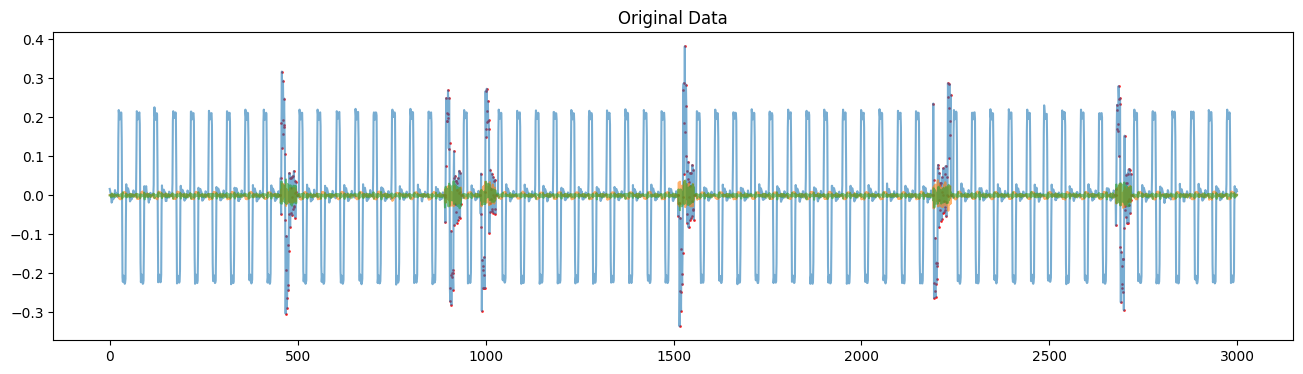

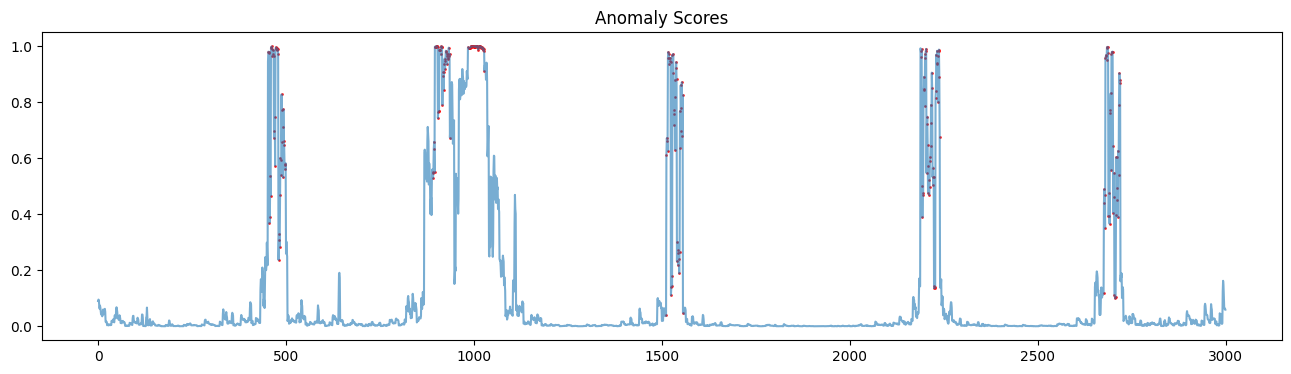

In [15]:
# Plot data and anomaly scores.
index = (18500, 21500)
# index = (0, len(test_data))  # interval for time steps
data_col_index = 0  # index of data column

label = test_label[index[0]:index[1]].astype(bool)
# print(test_label[index[0]:index[1]])

plt.figure(figsize=(16, 4))
plt.plot(test_data[index[0]:index[1], 0], alpha=0.6)
plt.plot(test_data[index[0]:index[1], 1], alpha=0.6)
plt.plot(test_data[index[0]:index[1], 2], alpha=0.6)
plt.scatter(np.arange(index[1]-index[0])[label], test_data[index[0]:index[1]][label, data_col_index],
            c='r', s=1, alpha=0.8)
plt.title('Original Data')
plt.show()

plt.figure(figsize=(16, 4))
plt.plot(anomaly_scores[index[0]:index[1], 0], alpha=0.6)
plt.scatter(np.arange(index[1]-index[0])[label], anomaly_scores[index[0]:index[1]][label, 0],
            c='r', s=1, alpha=0.8)
plt.title('Anomaly Scores')
plt.show()

In [12]:
# Compute precisions, recalls, F1-scores of the result.
# Standard metrics
best_eval = (0, 0, 0)
best_rate = 0
for rate in np.arange(0.001, 0.301, 0.001):
    evaluation = f1_score(test_label, anomaly_scores[:, 0], rate, False)
    if evaluation[2] > best_eval[2]:
        best_eval = evaluation
        best_rate = rate
print('Best F1-score without point adjustment')
print(f'anomaly rate: {best_rate:.3f} | precision: {best_eval[0]:.5f} | recall: {best_eval[1]:.5f} | F1-score: {best_eval[2]:.5f}\n')

# Metrics after point adjustment
best_eval = (0, 0, 0)
best_rate = 0
for rate in np.arange(0.001, 0.301, 0.001):
    evaluation = f1_score(test_label, anomaly_scores[:, 0], rate, True)
    if evaluation[2] > best_eval[2]:
        best_eval = evaluation
        best_rate = rate
print('Best F1-score with point adjustment')
print(f'anomaly rate: {best_rate:.3f} | precision: {best_eval[0]:.5f} | recall: {best_eval[1]:.5f} | F1-score: {best_eval[2]:.5f}\n')

Best F1-score without point adjustment
anomaly rate: 0.185 | precision: 0.83039 | recall: 0.79569 | F1-score: 0.81267

Best F1-score with point adjustment
anomaly rate: 0.105 | precision: 0.98652 | recall: 0.98393 | F1-score: 0.98523



In [51]:
# import numpy as np
# import os
# import pandas as pd

# data = pd.read_csv('/home/smaller/AnomalyBERT/data/tmp/I_06_14_undergain.csv')

# replacing_data = data[data['Anomaly_ID'] == 1].iloc[:,3:6].to_numpy()
# np.save('/home/smaller/AnomalyBERT/data/processed/semics_replacing_under.npy', replacing_data)

FileNotFoundError: [Errno 2] No such file or directory: '/home/smaller/AnomalyBERT/data/tmp/I_06_14_undergain.csv'